Topic Modelling in NIPS dataset
The NIPS dataset is a collection of research papers, along with the details of their authors. The journal is one of the top publications for Machine Learning related research. The intention of this project is to find the most interested research topics which would help us to understand the focus area in the field. 

Step 1: Importing the libraries

In [370]:
#Importing necessary libraries
import pandas as pd
import re
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Step 2: Loading the dataset

In [8]:
#Loading the dataframes
authors_df = pd.read_csv("C:\\Users\\princ\\Documents\\Machine Learning Projects\\Summer 24\\Natural Language Processing\\Topic Modelling on NIPS Papers\\dataset\\authors.csv")
paper_authors_df = pd.read_csv("C:\\Users\\princ\\Documents\\Machine Learning Projects\\Summer 24\\Natural Language Processing\\Topic Modelling on NIPS Papers\\dataset\\paper_authors.csv")
papers_df = pd.read_csv("C:\\Users\\princ\\Documents\\Machine Learning Projects\\Summer 24\\Natural Language Processing\\Topic Modelling on NIPS Papers\\dataset\\papers.csv")


In [11]:
#Updating the columns so that we can join the tables 
authors_df.columns = ['author_id', 'author_name']

In [13]:
#Merging two tables using the join operation
paper_authors_df = pd.merge( authors_df, paper_authors_df, on='author_id')

In [15]:
#Dropping the columns so that we can reuse the paperId column as the id for the table
paper_authors_df = paper_authors_df.drop(columns=['id'])

In [17]:
#Updating the names of the column and the paperId column is converted into id column - this will serve as the primary key for table going forward
paper_authors_df.columns = [ 'author_id', 'author_name', 'id']

In [24]:
#Grouping the papers by the paperId or id and then clustering the author_id and author_name
paper_authors_df = paper_authors_df.groupby(by='id')[['author_id', 'author_name']].agg(list).reset_index()
paper_authors_df

,id,author_id,author_name
0,1,"[1, 2]","[Hisashi Suzuki, Suguru Arimoto]"
1,2,[3],[Philip A. Chou]
2,3,"[252, 7094]","[Eric B. Baum, Frank Wilczek]"
3,4,"[4, 5]","[John C. Platt, Alan H. Barr]"
4,5,[6],[Ralph Linsker]
...,...,...,...
7233,7280,"[10437, 6369, 7267]","[Alexandru Niculescu-Mizil, Pradeep K. Ravikum..."
7234,7281,"[10376, 10425, 10426, 521, 8683]","[Venkatadheeraj Pichapati, Vaishakh Ravindraku..."
7235,7282,"[10427, 10428, 6868]","[Soumendu Sundar Mukherjee, Lizhen Lin, Purnam..."
7236,7283,"[10429, 8662]","[Ehsan Emamjomeh-Zadeh, David Kempe]"


Step 3: Text Preprocessing

In [180]:
#Finding the number of records that are not null 
i = 0
notNullRecordList =  papers_df['paper_text'].notna().to_list() 

count = 0
while i <= 7241:
    if notNullRecordList[i] == True:
        count += 1
    else:
        print(f"The null value is at {i} ")
    i += 1
    

The null value is at 7241 
7241


In [181]:
#Printing to see if there is any null value and found only one value or paper
for i in papers_df['paper_text'].notna():
    if i == False:
        print(f" The value is null ")

 The value is null 


In [182]:
#Need to drop the null values
papers_df = papers_df[papers_df['paper_text'].notna()]

In [183]:
#Find the blank values and convert into null values and drop them
def handleBlankValues( papers_df ):
    try:
        i = 0
        # print( papers_df.columns )
        while i < len( papers_df['paper_text'] ):
            if papers_df['paper_text'][i] == "":
                # print(f"The research paper number {i} is blank and will be updated by NaN")
                papers_df.loc['paper_text'][i] = np.NaN
            i += 1
        
        #Removing all the (new) null fields in the dataset
        papers_df = papers_df[papers_df['paper_text'].notna()]
    except:
        print(f"The exception has occurred")
        # print(f"{papers_df.columns}")

    return papers_df

In [184]:
#Remove the special characters in the text
def remove_special_characters( text ):
    special_character_regex = r'\s*(?:[\w_]*[/\\*,!~@#$%^&()_+=|}{":;?>.<,\'](?:[\w_]*[/\\*,!~@#$%^&()_+=|}{":;?>.<,\'])*[\w_]*)'
    
    text = re.sub( special_character_regex, "", text )
    
    return text

In [185]:
#A regex based method to remove content with square brackets
def remove_content_with_square_brackets( text ):
    square_bracket_regex = r'\s*(?:[\w_]*[\[\]](?:[\w_]*[\[\]])*[\w_]*)'
    
    text = re.sub( square_bracket_regex, "", text )
    
    return text

In [228]:
#A regex based method to remove content with numbers
def remove_content_with_numbers( text ):
    numbers_regex = r'\s*(?:[\w_]*[0123456789](?:[\w_]*[0123456789])*[\w_]*)'
    
    text = re.sub( numbers_regex, "", text )
    return text
    

In [227]:
#A test run to check the functionality
final_text = remove_content_with_numbers(remove_special_characters(remove_content_with_square_brackets(papers_df['paper_text'][0])))


 Before applying number removal <class 'str'>
 After applying number removal <class 'str'>


str

In [188]:
#A test run to check the functionality
remove_content_with_square_brackets("The [text] is [not] good fo]r hea[lth]y life")

'The is good life'

In [189]:
#A test run to check the functionality
remove_special_characters("I wasn't well yesterday, [and] an[d] god\is good/all the\time pai#d par$tn*r a!n a&d a)d said the wom@n of 4 daughters!!!")

'I well [and] an[d] the\time said the of 4'

In [233]:
#Common preprocessing the text to remove the irrelevant words
def preprocess_text( text ):

    #Removing any special characters in the text
    text = remove_special_characters( text )

    #Removing values with square brackets in the text
    text = remove_content_with_square_brackets( text )

    #Removing characters that have numbers in the text
    text = remove_content_with_numbers( text )
    
    return text

In [191]:
#Removes the stopwords in the text content and returns it
def remove_stopwords( text ):
    text = text.strip()
    words = text.split()
    ans = ""
    for word in words:
        if word not in stopwords.words('english'):
            ans += word
            ans += " "
    
    return ans

In [192]:
#Lemmatizes the text content
def lemmatize( text ):
    text = text.strip()
    words = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    ans = ""

    for word in words:
        lemmatized_word = lemmatizer.lemmatize( word )
        ans += lemmatized_word
        ans += " "
    
    return ans

In [193]:
#The noun alone are extracted from the text
def extract_nouns( text ):
    text = text.strip()
    words = nltk.word_tokenize( text )
    pos_tag_words = pos_tag( words )
    ans = ""

    for word, pos in pos_tag_words:
        if pos == 'NN':
            ans += word
            ans += " "
    
    return ans


In [194]:
#A test run to check the functionality
extract_nouns("The lazy brown frog jumps over the quick dog")

'brown frog dog '

In [195]:
#A test run to check the functionality
remove_stopwords( "i am going    to the park to chill with my friends ")

'going park chill friends '

In [196]:
#A test run to check the functionality
lemmatize("rocks corpus corpora pens cashier")

'rock corpus corpus pen cashier '

In [197]:
#Common methods to formulate the text into the expected format
def textProcess( text ):
    
    #Convert into string
    text = str(text) 

    #convert into lowercase
    text = text.lower()

    #Stop Word removal
    text = remove_stopwords( text )

    #Lemmatize the text
    text = lemmatize( text )

    #Extracting nouns
    text = extract_nouns( text )

    return text


In [235]:
#A test run to check the functionality
preprocessed_text = textProcess(preprocess_text( papers_df['paper_text'][0] ))
print( preprocessed_text )

self-organization database application hisashi suzuki suguru arimoto osaka japan method database application robot database associate input part self-organization aspect style latter half applicability letter recognition robot system introduction infinite infinite machine pair product x j estimation error decrease estimation error increase number expression performance lack consideration candidate j j let let advance database parameter type type machine parameter structure define candidate subset mapping x value parameter type parameter machine j approach number estimation error problem machine return structure f structure f achieve fast number parameter parameter j demand compactness structure conception design machine universality network sufficient knowledge f j structure alternative solution compactness structure cover combination base dimension network approximation institute physic topic network structure work procedure compute value coefficient discussion unit mark error combina

In [ ]:
#A test run to check the functionality
textProcess( paper_text_loc )

In [246]:
#The preprocessing and textprocessing is done from the paper_text and is saved in the same paper_text field
#Running time - 63 Mins
i = 0

papers_df = handleBlankValues( papers_df )

while i < len(papers_df['paper_text']):
    paper_text_loc = papers_df['paper_text'][i]
    paper_text_loc = preprocess_text( paper_text_loc )
    paper_text_loc = textProcess( paper_text_loc )
    papers_df.loc[ i, 'paper_text' ] = paper_text_loc
    i += 1

papers_df

,id,year,title,event_type,pdf_name,abstract,paper_text,1,2,3,...,7232,7233,7234,7235,7236,7237,7238,7239,7240,0
0,1.0,1987.0,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,self-organization database application hisashi...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,1987.0,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,field theory layer application science departm...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100.0,1988.0,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,covariance potentiation depression strength hi...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.0,1994.0,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,query construction network model gerhard paass...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001.0,1994.0,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,network cross denmark jesper vedelsby universi...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7236,994.0,1994.0,Single Transistor Learning Synapses,NaN,994-single-transistor-learning-synapses.pdf,Abstract Missing,transistor synapsis paul chris bradley carver ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7237,996.0,1994.0,"Bias, Variance and the Combination of Least Sq...",NaN,996-bias-variance-and-the-combination-of-least...,Abstract Missing,variance combination estimator meir faculty en...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7238,997.0,1994.0,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,time engine center describe analog implementat...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7239,998.0,1994.0,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,direction class model sundareswaran intelligen...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
#Dropping the extra columns that were created
#TODO: Not sure the reason why the extra columns were created need to look into it
i = 0

while i <= 7240:
    papers_df.drop( i, axis=1, inplace=True)
    i += 1

In [249]:
#Displaying the dataframe after the preprocesing
papers_df

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1.0,1987.0,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,self-organization database application hisashi...
1,10.0,1987.0,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,field theory layer application science departm...
2,100.0,1988.0,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,covariance potentiation depression strength hi...
3,1000.0,1994.0,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,query construction network model gerhard paass...
4,1001.0,1994.0,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,network cross denmark jesper vedelsby universi...
...,...,...,...,...,...,...,...
7236,994.0,1994.0,Single Transistor Learning Synapses,NaN,994-single-transistor-learning-synapses.pdf,Abstract Missing,transistor synapsis paul chris bradley carver ...
7237,996.0,1994.0,"Bias, Variance and the Combination of Least Sq...",NaN,996-bias-variance-and-the-combination-of-least...,Abstract Missing,variance combination estimator meir faculty en...
7238,997.0,1994.0,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,time engine center describe analog implementat...
7239,998.0,1994.0,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,direction class model sundareswaran intelligen...


Step 4: Exploratory Data Analysis

In [256]:
#A method to find the word count of the processed text for each paper
def find_word_count( papers_subset_df ):

    i = 0

    while i < len( papers_subset_df ):
        text = papers_subset_df['paper_text'][i]
        words = text.split()
        papers_subset_df.loc[i, 'num_words'] = len( words )
        i += 1
        # if i == 10:
        #     break
    return papers_subset_df

In [264]:
#A test run to check the functionality
papers_df = find_word_count(papers_df)

In [265]:
#Creating a subset of the dataframe
papers_subset_df = papers_df[['id', 'paper_text','num_words']]

In [266]:
#Displaying the first 5 records
papers_subset_df.head(5)

,id,paper_text,num_words
0,1.0,self-organization database application hisashi...,547.0
1,10.0,field theory layer application science departm...,487.0
2,100.0,covariance potentiation depression strength hi...,497.0
3,1000.0,query construction network model gerhard paass...,580.0
4,1001.0,network cross denmark jesper vedelsby universi...,556.0


In [270]:
#Creating an array with default values
wordCounter = [[0]*5]

In [275]:
#A method to find the occurrences of the word
def findWordCounter( papers_df, wordCounter ):
    i = 0

    while i < len( papers_df ):
        num_words = papers_df['num_words'][i]

        if num_words < 500:
            wordCounter[0][0] += 1
        elif num_words < 1000:
            wordCounter[0][1] += 1
        elif num_words < 1500:
            wordCounter[0][2] += 1
        elif num_words < 2000:
            wordCounter[0][3] += 1
        else:
            wordCounter[0][4] += 1
        
        i += 1

    return wordCounter

In [277]:
#Finding the usages of the word count for each paper
wordCounter = findWordCounter( papers_subset_df, wordCounter )

In [292]:
#Due to an incorrect size (2D) for the array instead of the expected (1D), we had to remove the outer array
wordCounter = wordCounter[0]

Text(0, 0.5, 'Number of Documents')

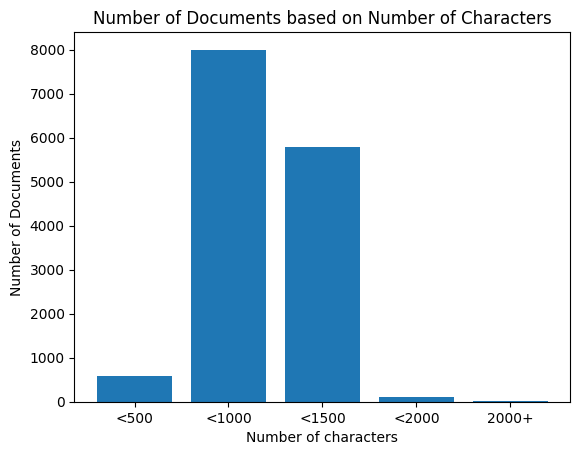

In [296]:
#Plotting the bar chart with the frequencies of the word count
plt.bar(['<500', '<1000', '<1500', '<2000', '2000+'], wordCounter)
plt.title("Number of Documents based on Number of Characters")
plt.xlabel("Number of characters")
plt.ylabel("Number of Documents")

In [314]:
#A method to find the top n_gram in the documents
def get_top_n_gram( data, n_gram=0, top=None):
    count_vectorizer = CountVectorizer( ngram_range=(n_gram, n_gram), stop_words='english' ).fit(data)
    bag_of_words = count_vectorizer.transform( data )
    # print(bag_of_words)
    sum_words = bag_of_words.sum( axis = 0 )
    # print(sum_words)
    words_freq = [ (word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items() ]
    words_freq = sorted( words_freq, key = lambda x : x[1] , reverse=True)
    return words_freq[:top]


In [336]:
#A field that is used to store the labels from 1-30 but will be unused
top30_labels = [ str(i+1) for i in range(30) ]

In [325]:
#The cell in which the n_gram is calculated
top_30_unigram = get_top_n_gram( papers_df['paper_text'], n_gram=1, top=30 )
top_30_bigram = get_top_n_gram( papers_df['paper_text'], n_gram=2, top=30 )
top_30_trigram = get_top_n_gram( papers_df['paper_text'], n_gram=3, top=30 )

In [330]:
#Printing the length and typs of the records
len(top_30_unigram)
print(f" {type(top_30_unigram)} {type(top30_labels)} ")

 <class 'list'> <class 'list'> 


In [350]:
#A method to plot the n_gram chart
def plot_n_gram_chart( data, n_gram=None ):
    n_gram_phrase = []
    n_gram_count = []

    if n_gram == 1 :
        n_gram_title = 'Unigram'
    elif n_gram == 2:
        n_gram_title = 'Bigram'
    elif n_gram == 3:
        n_gram_title = 'Trigram'

    for i in range(30):
        n_gram_phrase.append( data[i][0] )
        n_gram_count.append( data[i][1] )
    
    plt.barh( n_gram_phrase, n_gram_count )
    plt.xlabel(f"Occurrences")
    plt.ylabel(f"Words")
    plt.title(f"Top 30 {n_gram_title}")

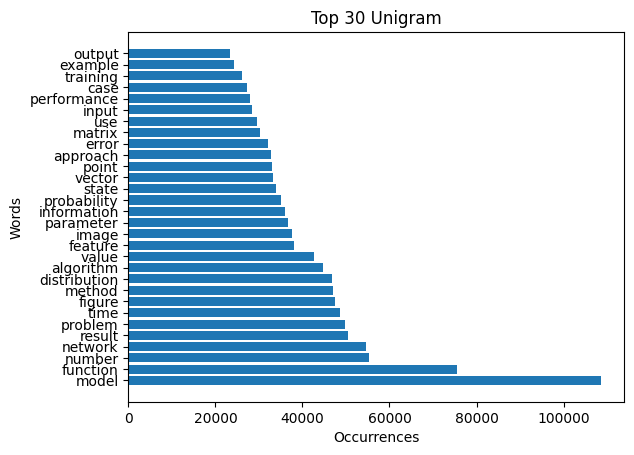

In [351]:
#Plotting the graph for unigram
plot_n_gram_chart( top_30_unigram, n_gram=1 )

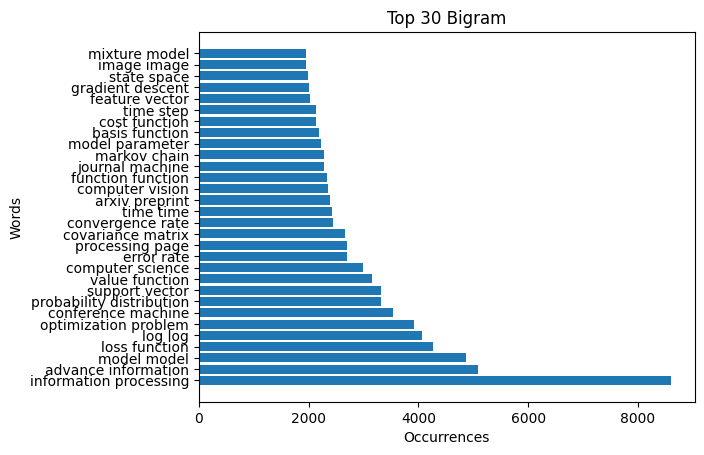

In [353]:
#Plotting the graph for bigram
plot_n_gram_chart( top_30_bigram, n_gram=2 )

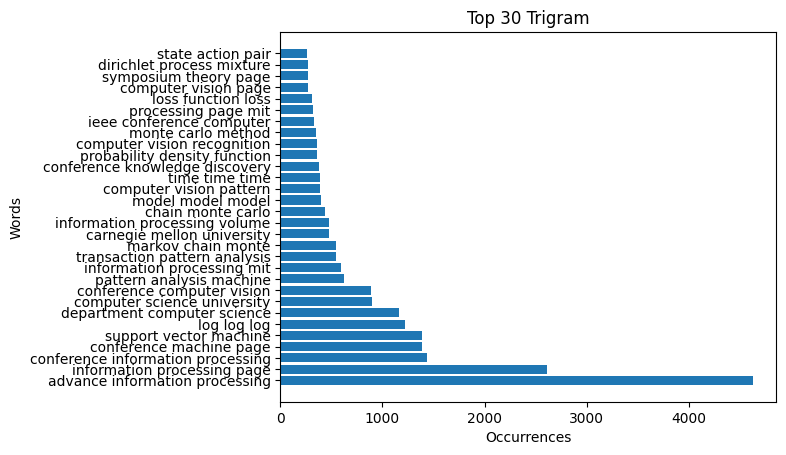

In [354]:
#Plotting the graph for trigram
plot_n_gram_chart( top_30_trigram, n_gram=3 )

Step 5: Feature Extraction

In [355]:
#Creating a TfIdvectorizer
vectorizer = TfidfVectorizer( max_df=0.95, min_df=5, stop_words='english')

In [356]:
#Fitting and training with the dataset
vectorizer_model = vectorizer.fit_transform( papers_df['paper_text'] )

In [361]:
#A sample to display the top features
vectorizer.get_feature_names_out()[:10]

array(['aa', 'aaa', 'aaai', 'aad', 'aaditya', 'aalborg', 'aalto', 'aapo',
       'aaron', 'aarti'], dtype=object)

In [359]:
#Finding the number of features
len(vectorizer.get_feature_names_out())

15568

Step 6: Topic Modelling Using NMF, LDA, and LSA

The following section had some code reused from
https://www.kaggle.com/code/pranjalsoni17/topic-modelling-using-lda

In [371]:
#Splitting the data
papers_content = papers_df['paper_text'].apply( lambda x : x.split() )
id2word = corpora.Dictionary(papers_content)

In [372]:
#Tokenizing the content
corpus = [ id2word.doc2bow(paper) for paper in papers_content]

In [375]:
#Printing the records for one of the corpus example
corpora_example = [ [ (id2word[id], freq) for id, freq in corpora ] for corpora in corpus[:2]]
corpora_example[0][:50]

[('adap', 1),
 ('advance', 1),
 ('analysis', 1),
 ('angle', 1),
 ('applicability', 1),
 ('application', 5),
 ('approach', 3),
 ('approximation', 1),
 ('architecture', 2),
 ('area', 6),
 ('arimoto', 1),
 ('arrange', 1),
 ('attain', 1),
 ('author', 1),
 ('automation', 1),
 ('b', 1),
 ('base', 2),
 ('blem', 1),
 ('bottom', 2),
 ('boundary', 1),
 ('brush', 1),
 ('bstitu', 1),
 ('calibration', 1),
 ('call', 1),
 ('camera', 9),
 ('candidate', 4),
 ('capacity', 1),
 ('case', 1),
 ('change', 3),
 ('character', 2),
 ('check', 1),
 ('cmu', 1),
 ('collection', 1),
 ('collision', 1),
 ('combination', 2),
 ('compactness', 2),
 ('compression', 3),
 ('compu', 1),
 ('computation', 2),
 ('conception', 1),
 ('conclusion', 1),
 ('configuration', 1),
 ('consideration', 1),
 ('consistency', 1),
 ('construction', 2),
 ('control', 1),
 ('cost', 3),
 ('counter', 1),
 ('course', 1),
 ('cover', 1)]

In [385]:
#A Lda model is used
lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = 10,
    random_state = 42,
    update_every = 1,
    chunksize = 100,
    passes = 10,
    alpha = 'symmetric',
    per_word_topics = True,
    eta = 0.6)

In [379]:
doc_lda = lda_model[corpus]

In [387]:
#Visualizing the model result
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.273943 -0.064266       1        1  43.241801
0      0.223623 -0.044827       2        1  20.518687
8      0.157774  0.046850       3        1  10.909886
2      0.205775  0.094313       4        1  10.068558
9      0.125486  0.175661       5        1   8.820177
7      0.083048 -0.219113       6        1   5.846872
6     -0.269806  0.002581       7        1   0.203075
5     -0.261839  0.006207       8        1   0.174621
1     -0.273755  0.000907       9        1   0.153752
4     -0.264250  0.001688      10        1   0.062572, topic_info=                     Term           Freq          Total Category  logprob  \
133               network   56375.000000   56375.000000  Default  30.0000   
93                  image   34948.000000   34948.000000  Default  29.0000   
129                 model  105308.000000  105308.000000  Default  28.0000   
402               feature   31798.000000   31798.000000  Default  27.0000   
350                 state   30069.000000   30069.000000  Default  26.0000   
...                   ...            ...            ...      ...      ...   
12245                 gdl       1.084673      17.714834  Topic10  -8.2468   
15423            knockout       1.032669      14.897714  Topic10  -8.2960   
91112  hypercontractivity       1.304645     132.108221  Topic10  -8.0622   
77420          mallowsmpi       0.925626      35.151658  Topic10  -8.4054   
93976                flee       0.929378      48.627635  Topic10  -8.4014   

       loglift  
133    30.0000  
93     29.0000  
129    28.0000  
402    27.0000  
350    26.0000  
...        ...  
12245   4.5835  
15423   4.7075  
91112   2.7589  
77420   3.7397  
93976   3.4192  

[646 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6055      1  0.707242    
6055      2  0.211117    
6055      3  0.010556    
6055      4  0.010556    
6055      5  0.010556    
...     ...       ...  ...
5849      1  0.073778    
5849      2  0.073778    
5849      3  0.073778    
5849      5  0.073778    
5849      9  0.737784    

[3222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 3, 10, 8, 7, 6, 2, 5])

In [388]:
#Printing the perplexity score
print(f"Perplexity is {lda_model.log_perplexity(corpus)}")

Perplexity is -7.3206669221567235


In [389]:
text = papers_content

In [392]:
#Finding the coherence score
coherence_model = CoherenceModel( model = lda_model, texts=text, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [393]:
#Displaying the coherence score
print(f"Coherence Score is {coherence_score}")

Coherence Score is 0.39573690306757897


In [400]:
#Defining the parameters for grid search cv
no_of_topics = [5, 10, 15, 20]
valid_alphas = ['symmetric', 0.5]
valid_betas = ['auto', 0.5, 0.7]

In [398]:
#A method to find the coherence score dynamically depending on the parameters - num_topic, alpha, and beta
def get_coherence_score( num_topic = 1, alpha = 0.3, beta = 0.3 ):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus = corpus,
        id2word = id2word,
        num_topics = num_topic,
        alpha = alpha,
        eta = beta,
        random_state = 1,
        update_every = 1,
        chunksize = 10,
        passes = True,
        per_word_topics = True
    )
    perplexity = lda_model.log_perplexity(corpus)
    coherence_model = CoherenceModel( model = lda_model, texts = text, dictionary = id2word, coherence = 'c_v' )
    coherence_score = coherence_model.get_coherence()

    return coherence_score


In [401]:
#Running the grid search for each of the hyperparameter
for num_topic in no_of_topics:
    for alpha in valid_alphas:
        for beta in valid_betas:
            coherence_score = get_coherence_score( num_topic, alpha, beta )
            print(f"The factors are {num_topic} {alpha} {beta} with the coherence score as {coherence_score} ")


The factors are 5 symmetric auto with the coherence score as 0.4306410298391164 
The factors are 5 symmetric 0.5 with the coherence score as 0.4423419742621165 
The factors are 5 symmetric 0.7 with the coherence score as 0.45400399405258146 
The factors are 5 0.5 auto with the coherence score as 0.4333786283153886 
The factors are 5 0.5 0.5 with the coherence score as 0.44222841312115646 
The factors are 5 0.5 0.7 with the coherence score as 0.46653425065389253 
The factors are 10 symmetric auto with the coherence score as 0.4665974484315486 
The factors are 10 symmetric 0.5 with the coherence score as 0.4684760403917143 
The factors are 10 symmetric 0.7 with the coherence score as 0.47293539516702987 
The factors are 10 0.5 auto with the coherence score as 0.4506234593905954 
The factors are 10 0.5 0.5 with the coherence score as 0.46207619456680166 
The factors are 10 0.5 0.7 with the coherence score as 0.454235703446842 
The factors are 15 symmetric auto with the coherence score as 

In [404]:
#Running the LDA model for the best parameters
n = 10
alpha = 'symmetric'
beta = 0.7

final_lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics= n,
    alpha= alpha,
    eta = beta,
    random_state = 42,
    update_every=1,
    passes=10,
    per_word_topics=True
)

In [405]:
#Finding and printing the best scores for the best model
perplexity_score = final_lda_model.log_perplexity(corpus)

final_coherence_model = CoherenceModel( model = final_lda_model, texts=text, dictionary=id2word, coherence='c_v')

final_coherence_lda = final_coherence_model.get_coherence()

print(f"The best model's coherence is {final_coherence_lda}")

The best model's coherence is 0.4956253747992914


In [406]:
#Visualizing the best model's performance
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.273943 -0.064266       1        1  43.241801
0      0.223623 -0.044827       2        1  20.518658
8      0.157774  0.046850       3        1  10.909809
2      0.205775  0.094313       4        1  10.068580
9      0.125486  0.175661       5        1   8.820140
7      0.083048 -0.219113       6        1   5.846912
6     -0.269806  0.002581       7        1   0.203066
5     -0.261839  0.006207       8        1   0.174624
1     -0.273755  0.000907       9        1   0.153341
4     -0.264250  0.001688      10        1   0.063069, topic_info=                     Term           Freq          Total Category  logprob  \
133               network   56375.000000   56375.000000  Default  30.0000   
93                  image   34948.000000   34948.000000  Default  29.0000   
129                 model  105308.000000  105308.000000  Default  28.0000   
402               feature   31798.000000   31798.000000  Default  27.0000   
350                 state   30069.000000   30069.000000  Default  26.0000   
...                   ...            ...            ...      ...      ...   
12245                 gdl       1.093299      17.723214  Topic10  -8.2468   
15423            knockout       1.040882      14.905698  Topic10  -8.2960   
91112  hypercontractivity       1.315021     132.117821  Topic10  -8.0622   
77420          mallowsmpi       0.932987      35.158815  Topic10  -8.4054   
93976                flee       0.936769      48.634653  Topic10  -8.4014   

       loglift  
133    30.0000  
93     29.0000  
129    28.0000  
402    27.0000  
350    26.0000  
...        ...  
12245   4.5830  
15423   4.7070  
91112   2.7588  
77420   3.7394  
93976   3.4190  

[646 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6055      1  0.707338    
6055      2  0.211146    
6055      3  0.010557    
6055      4  0.010557    
6055      5  0.010557    
...     ...       ...  ...
5849      1  0.073921    
5849      2  0.073921    
5849      3  0.073921    
5849      5  0.073921    
5849      9  0.739207    

[3222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 9, 3, 10, 8, 7, 6, 2, 5])

#TODO: Need to do the Topic Modelling using NMF and LSA later
The work on the NMF and LSA will be done later